In [5]:
import pandas as pd
import numpy as np
import math
from datetime import timedelta
import matplotlib.pyplot as plt
import pyentrp.entropy as ent
from datetime import datetime

In [6]:
# Reading the synthetic rooftop PV dataset and site details file associated with it
# (Note that the results produced using the dummy dataset are likely to be different with the ones
# shown in the research article)

input_df = pd.read_csv("Input_data/synthetic_rooftop_data.gz", compression='gzip')
input_df.index = pd.to_datetime(input_df["t_stamp_utc"])
input_df = input_df.drop(columns=["t_stamp_utc"])
site_details = pd.read_csv("Input_data/site_details.csv", index_col=0)
all_sites = site_details.index

In [7]:
# Loads the WPE values dataframe and the AUS cities/states dataframes

wpe_val_df = pd.read_pickle("Processed_data/WPEvalues_10minminresamp_6dim.pkl")
states_df = pd.read_pickle("Input_data/States_DataFrame.pkl")
cities_df = pd.read_pickle("Input_data/Cities_DataFrame.pkl")

In [ ]:
# Creates a list of postcodes
postcode_list = list()
for site_id in all_sites:
    postcode_list.append(int(site_details.loc[int(site_id), "postcode"]))
postcode_list.sort()

# Creates a dictionary of postcodes and number of houses at each
postcode_dict = dict()
for i in postcode_list:
    if i in postcode_dict.keys():
        postcode_dict[i] = postcode_dict[i] + 1
    else:
        postcode_dict[i] = 1
postcode_df = pd.DataFrame(list(postcode_dict.items()), columns=['ID', 'WPEVal'])

# Creates a dataframe of postcodes and their respective states and number of houses
postcode_df = pd.DataFrame(list(postcode_dict.items()), columns=['postcode', 'NumberofHouses'])

In [ ]:
# Catch the latitude and longitude of the postcodes from Google Maps (I saved the results, so no need to run it)

import googlemaps

gmaps = googlemaps.Client(key= ...) # ENTER Google Maps key
counter = 0
for i in postcode_df.index:
    Adress = str(postcode_df.loc[i, 'postcode']) + " postcode, Australia"
    geocode_result = gmaps.geocode(Adress)
    postcode_df.loc[i, 'lat'] = geocode_result[0]['geometry']['location']['lat']
    postcode_df.loc[i, 'lng'] = geocode_result[0]['geometry']['location']['lng']

In [ ]:
# Calculating the WPE of rooftop PV generation at each postcode

for index_postcode in postcode_df.index:
    site_list = list()
    sum_wpe = 0
    for index_site in all_sites:
        if int(postcode_df.loc[index_postcode,'postcode']) == int(site_details.loc[int(index_site),'postcode']):
            site_list.append(index_site)
            sum_wpe = sum_wpe + wpe_val_df.loc[wpe_val_df['ID'] == index_site,'WPEVal'].iloc[0]
    if sum_wpe != 0:
        postcode_df.loc[index_postcode,'AverageWPE'] = sum_wpe / len(site_list)
    else:
        postcode_df.loc[index_postcode,'AverageWPE'] = 0
#postcode_df.to_pickle('PostcodeLocationDF.pkl')

In [ ]:
# Reading the pre-generated dataframe of rooftop PV postcodes that includes their lat, lng, and the WPE at
# their locations Created in the past three cells using the actual PV generation data

postcode_df = pd.read_pickle("Processed_data/PostcodeLocationDF.pkl")

In [15]:
# Making the postcode groups dataframe 2 (Creating the final dataframe)

import geopy.distance

postcode_groups_dict = dict()
already_categorized = list()
radius_to_merge = 25 #km

for i in postcode_df.index:
    if i in already_categorized:
        continue
    postcode_groups_dict[i] = list()
    coords_1 = (postcode_df.loc[i, 'lat'], postcode_df.loc[i, 'lng'])
    for postcode_index in postcode_df.index:
        if postcode_index in already_categorized:
            continue
        coords_2 = (postcode_df.loc[postcode_index, 'lat'], postcode_df.loc[postcode_index, 'lng'])
        if geopy.distance.distance(coords_1, coords_2).km < radius_to_merge:
            postcode_groups_dict[i].append(postcode_df.loc[postcode_index, 'postcode'])
            already_categorized.append(postcode_index)


dataframe_to_display = pd.DataFrame()
k = 0
for i in postcode_groups_dict.keys():
    sites_number = 0
    lat = 0
    lng = 0
    avg_wpe = 0
    for postcode_index in postcode_groups_dict[i]:
        sites_number = sites_number + postcode_df.loc[postcode_df[postcode_df['postcode']
                                                == postcode_index].index, 'NumberofHouses'].iloc[0]

        lat = lat + postcode_df.loc[postcode_df[postcode_df['postcode'] == postcode_index].index, 'lat'].iloc[0]\
              * postcode_df.loc[postcode_df[postcode_df['postcode'] == postcode_index].index, 'NumberofHouses'].iloc[0]

        lng = lng + postcode_df.loc[postcode_df[postcode_df['postcode'] == postcode_index].index, 'lng'].iloc[0]\
              * postcode_df.loc[postcode_df[postcode_df['postcode'] == postcode_index].index, 'NumberofHouses'].iloc[0]

        avg_wpe = avg_wpe + postcode_df.loc[postcode_df[postcode_df['postcode'] ==
                postcode_index].index, 'AverageWPE'].iloc[0] * \
                  postcode_df.loc[postcode_df[postcode_df['postcode'] == postcode_index].index, 'NumberofHouses'].iloc[0]

    lat = lat / sites_number
    lng = lng / sites_number
    avg_wpe = avg_wpe / sites_number

    dataframe_to_display.loc[k, 'NumberofHouses'] = sites_number
    dataframe_to_display.loc[k, 'lat'] = lat
    dataframe_to_display.loc[k, 'lng'] = lng
    dataframe_to_display.loc[k, 'AverageWPE'] = avg_wpe
    k += 1

# Filtering out postcodes with houses less than 2 from the dataframe (NewPostcodeDF is the one fed into the map code)
dataframe_to_display = dataframe_to_display[dataframe_to_display['NumberofHouses'] > 1]

C:\Users\a1792406\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/export?bbox=135.3,-39.0,153.80000000000004,-29.800000000000004&bboxSR=4326&imageSR=4326&size=1500,745&dpi=96&format=png32&transparent=true&f=image


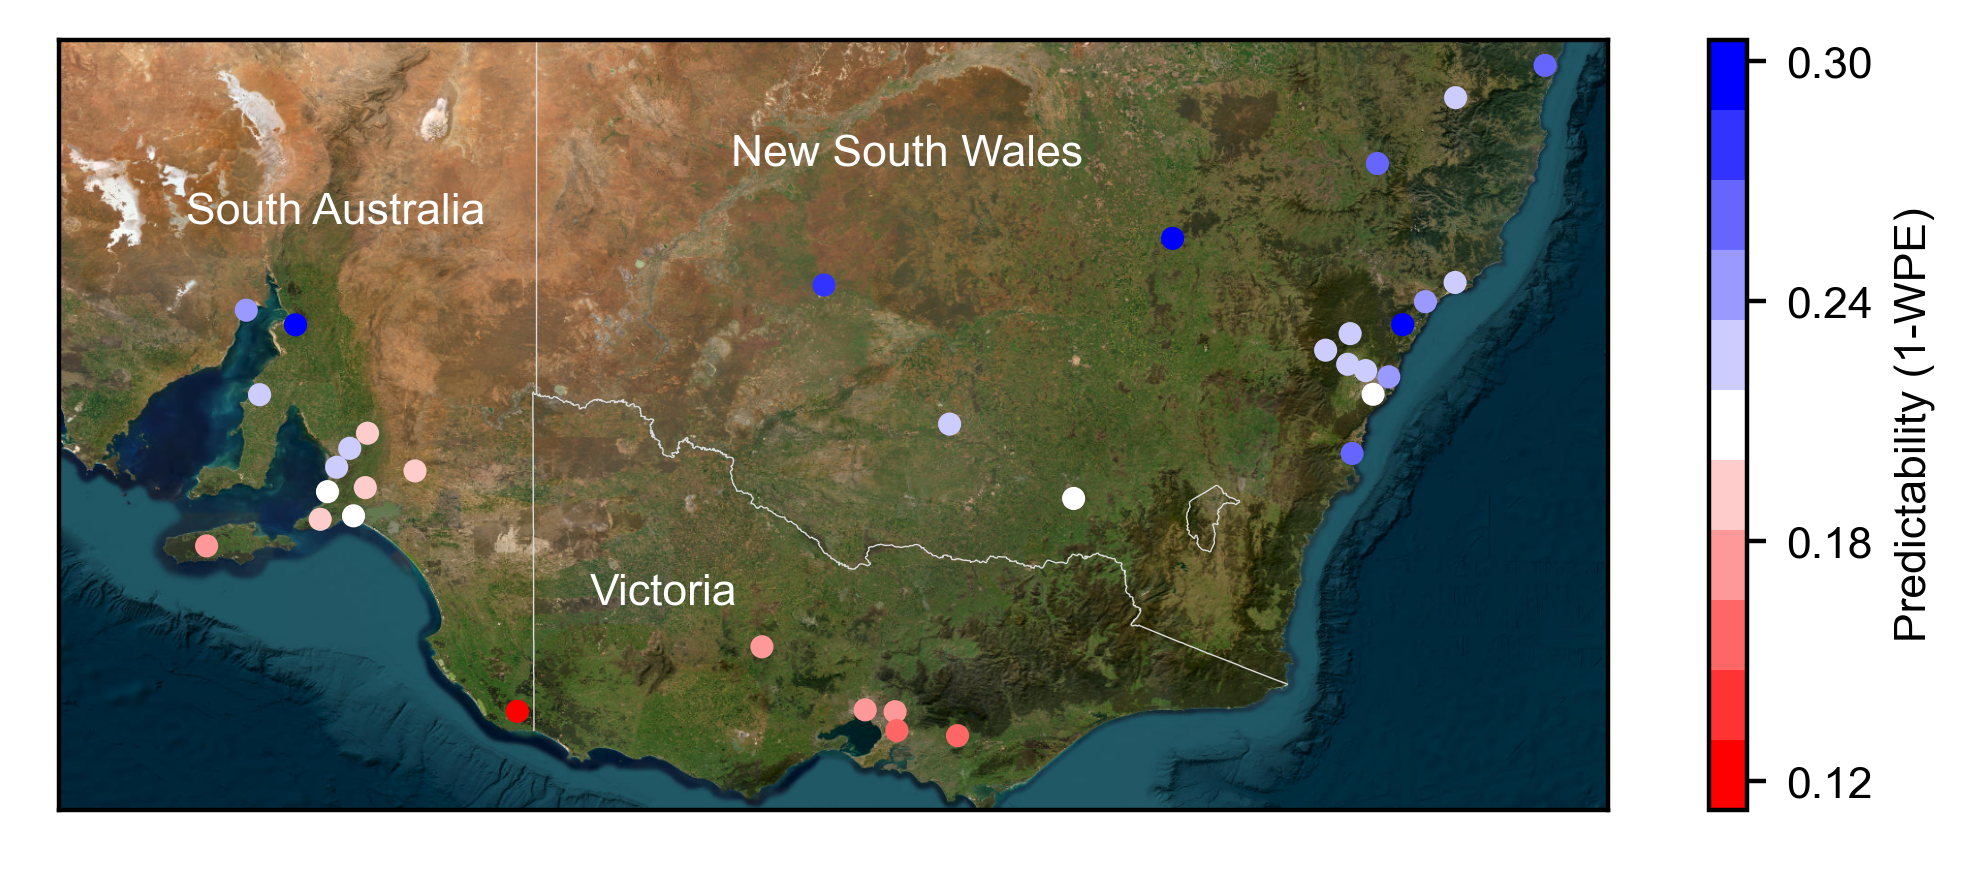

In [16]:
# Plotting Figure 10

from mpl_toolkits.basemap import Basemap
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
import matplotlib.cm as cm


plt.style.use('default')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = 8
plt.rcParams['figure.dpi'] = 400
plt.rcParams['savefig.dpi'] = 400

fig = plt.figure(figsize = (6.5,2.5))

m = Basemap(projection='cyl', resolution='h', llcrnrlat=-39, urcrnrlat=-29.8, llcrnrlon=135.3, urcrnrlon=153.8)
m.arcgisimage(service='World_Imagery', xpixels = 1500, verbose= True)
m.drawstates(linewidth = 0.25, color='gainsboro')

# Writing the name of states and cities
for i in states_df.index:
    if (i == 3) or (i == 4):
        continue
    plt.text(states_df.loc[i, 'lng'], states_df.loc[i, 'lat'], states_df.loc[i, "States"], color = 'white')

lat = dataframe_to_display['lat'].tolist()
lng = dataframe_to_display['lng'].tolist()
scolor = [1 - i for i in dataframe_to_display['AverageWPE'].tolist()]
size = 10

cm1 = cm.get_cmap('bwr_r', 11)
m.scatter(lng, lat, latlon=True, c=scolor, s=size, cmap=cm1, alpha = 1, zorder = 4)

cbar =  plt.colorbar(ticks=[0.12, 0.18, 0.24, 0.30])

plt.clim(0.99 - max(dataframe_to_display['AverageWPE']), 1 - min(dataframe_to_display['AverageWPE']))
cbar.set_label('Predictability (1-WPE)')
plt.show()
#plt.savefig("Figure10.pdf", dpi=400, bbox_inches='tight')